In [9]:
from tensorflow.keras import layers, models, backend, utils, metrics, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from PIL import Image
from wand.image import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics as skmetrics
import numpy as np
import seaborn as sns
import os
import pandas as pd
import glob
import errno
import scipy
from scipy import ndimage
import imageio


In [13]:
DIR_PREFIX  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/'

def load_dataset(path):
    dataset = {"image_path":[],"img_status":[],"where":[]}
    for status in os.listdir(path):
        for image in glob.glob(path+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append("train")
    dataset = pd.DataFrame(dataset)
    dataset.value_counts("img_status")
    real = dataset.value_counts("img_status")[1]
    fake = dataset.value_counts("img_status")[0]

    print(f"Real: {real},\nFake: {fake}\n")
    sns.countplot(dataset["img_status"])
    plt.show()
    return dataset

def view_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        plt.title(dataset.loc[random, "img_status"], size = 10) 
        plt.xticks([])
        plt.yticks([])

    plt.show()
    
def predict(img_path):
    input_arr = []
    count = 0
#     img_path = img_path.replace(DIR_PREFIX,'./output/')
    image = preprocessing.image.load_img(
        img_path, grayscale=False, color_mode="rgb", target_size=(256, 256, 3)
    )
    i = preprocessing.image.img_to_array(image)
    input_arr = np.array([i])
    predictions = model.predict(input_arr)
    return predictions[0]

def predict_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        predicted = predict(dataset.loc[random,"image_path"]);
        plt.title(f"{dataset.loc[random, 'img_status']} accuracy: {predicted}", size = 10) 
        plt.xticks([])
        plt.yticks([])
    

def convert_to_edge(dir_name='train'):
    try:
        os.mkdir('./output/'+dir_name)
        os.mkdir('./output/'+dir_name+'/fake')
        os.mkdir('./output/'+dir_name+'/real')
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    i = 0
    print('data processed for '+dir_name)
    for filename in os.listdir(DIR_PREFIX+dir_name):
        f = os.path.join(DIR_PREFIX+dir_name, filename)
        # checking if it is a file
        if os.path.isdir(f):
            convert_to_edge(dir_name+'/'+filename)
        else:
            i = i+1
            im = imageio.imread(f)
            im = im.astype('int32')
            dx = ndimage.sobel(im, 0)  # horizontal derivative
            dy = ndimage.sobel(im, 1)  # vertical derivative
            mag = np.hypot(dx, dy)  # magnitude
            mag *= 255.0 / np.max(mag)  # normalize (Q&D)
            imageio.imsave(f.replace(DIR_PREFIX,'./output/'), mag)
            print(i, end='\r')
            
try:
    os.mkdir('./output')
except OSError as exc:
    pass

Real: 4000,
Fake: 4000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


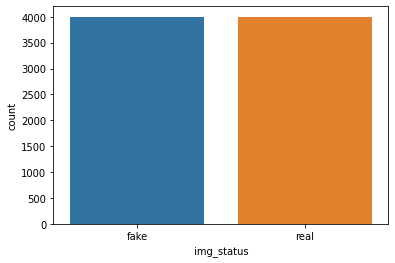

In [3]:
path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/train'
train_dataset = load_dataset(path)

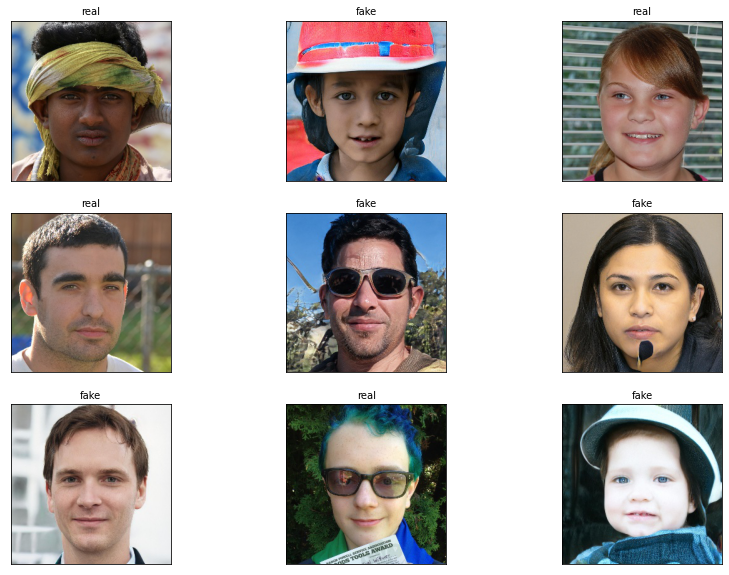

In [4]:
view_dataset(train_dataset)

In [6]:
# convert_to_edge('train')
# convert_to_edge('valid')
# convert_to_edge('test')

In [ ]:
# path  = './output/train'
# train_dataset_preprocessed = load_dataset(path)
# view_dataset(train_dataset_preprocessed)

In [12]:
base_path = './output/'
train_flow = preprocessing.image_dataset_from_directory(
    '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/train',
    image_size=(256, 256),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
test_flow = preprocessing.image_dataset_from_directory(
    '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test',
    image_size=(256, 256),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
valid_flow = preprocessing.image_dataset_from_directory(
    '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/valid',
    image_size=(256, 256),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
train_flow.class_names

Found 8000 files belonging to 2 classes.
Found 3587 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


['fake', 'real']

In [14]:
model = models.Sequential()

model.add(
    layers.Conv2D(32, (3, 3),activation='relu', input_shape=(256, 256, 3))
)

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# output node 1 means prediction in 0 -- 1 and decimals
# output node 2 means predication of 0 or 1 no decimals
model.summary()

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = [
        'accuracy'
    ]
)

# model = models.Sequential()

# model.add(
#     layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[150, 150, 3]))

# model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
# model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
# model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
# model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
# model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
# model.add(layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
# model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
# model.add(layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
# model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
# model.add(layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
# model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))
# model.summary()

# model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 256)      

In [15]:
# train_steps = 4000//64
# valid_steps = 4000//64

hist = model.fit(
    train_flow,
    epochs=10,
    validation_data=valid_flow,
    batch_size=64
)

Epoch 1/10
125/125 [==============================] - 20s 144ms/step - loss: 2.0312 - accuracy: 0.5161 - val_loss: 0.6898 - val_accuracy: 0.5145
Epoch 2/10
125/125 [==============================] - 18s 142ms/step - loss: 0.6795 - accuracy: 0.5610 - val_loss: 0.6609 - val_accuracy: 0.6060
Epoch 3/10
125/125 [==============================] - 18s 138ms/step - loss: 0.6379 - accuracy: 0.6390 - val_loss: 0.6375 - val_accuracy: 0.6325
Epoch 4/10
125/125 [==============================] - 18s 142ms/step - loss: 0.5946 - accuracy: 0.6856 - val_loss: 0.6090 - val_accuracy: 0.6715
Epoch 5/10
125/125 [==============================] - 17s 133ms/step - loss: 0.5535 - accuracy: 0.7204 - val_loss: 0.5876 - val_accuracy: 0.6980
Epoch 6/10
125/125 [==============================] - 18s 141ms/step - loss: 0.5187 - accuracy: 0.7440 - val_loss: 0.6185 - val_accuracy: 0.6695
Epoch 7/10
125/125 [==============================] - 19s 145ms/step - loss: 0.4901 - accuracy: 0.7646 - val_loss: 0.5631 - val_ac

In [ ]:
y_pred = model.predict(test_flow)
y_pred

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test'
test_dataset = load_dataset(path)
predict_dataset(test_dataset)